In [ ]:
# !pip install pyspark
# !pip install findspark

In [2]:
import zipfile as zf
import io
import pandas as pd
import os
from pyspark import SparkConf
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql import Catalog
import pyspark.sql.functions as psf
from pyspark.sql.functions import lit, col,sum,avg,max,first,min,mean
import pyspark.ml as Pipeline
import pyspark.ml.pipeline as pmpip
import pyspark.ml.param as pmparam
from pyspark.ml.param.shared import HasInputCol,HasOutputCol
from pyspark.sql.types import StructType,StructField,StringType,IntegerType,FloatType
from pyspark.sql.functions import monotonically_increasing_id 
from pyspark.sql.functions import struct,array,lit
from pyspark.streaming import StreamingContext

In [3]:
df = pd.read_csv('data/Amharic News Dataset.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51483 entries, 0 to 51482
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  51470 non-null  object
 1   category  51482 non-null  object
 2   date      51483 non-null  object
 3   views     51483 non-null  object
 4   article   51483 non-null  object
 5   link      51483 non-null  object
dtypes: object(6)
memory usage: 2.4+ MB


In [5]:
#  create spark connection

# def create_spark_connection(**kwargs):
#     app_name = kwargs.get('app_name','SparkDemo')
#     master = kwargs.get('master','yarn')
#     ui_port = kwargs.get('ui_port','4040')
#     driver_port = kwargs.get('driver_port','8887')
#     cores_max = kwargs.get('cores_max','4')
#     executor_cores = kwargs.get('executor_cores','4')
#     driver_memory = kwargs.get('driver_memory','8g') 
#     executor_memory = kwargs.get('executor_memory','8g')
#     dynamicAllocation = kwargs.get('dynamicAllocation','false')
#     aqe = kwargs.get('aqe', 'true')
#     sql_shuffle_partitions = kwargs.get('sql_shuffle_partitions',200)
    

In [6]:
spark_conf = SparkConf()
spark_conf.setAll([
    ('spark.master', 'local'),
    ('spark.app.name', 'spark_transform'),
    ('spark.submit.deployMode', 'client'),
    ('spark.ui.showConsoleProgress', 'true'),
    ('spark.eventLog.enabled', 'false'),
    ('spark.logConf', 'false'),
    ('spark.driver.host', 'localhost'),
    ('spark.driver.memory','4g')
])

spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/08 12:41:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [7]:
spark

In [8]:
path  = '/mnt/10ac-batch-6/bucket/Amharic News Dataset.csv'

In [9]:
df_spark = spark.read.csv(path,header=True,inferSchema=True)

In [10]:
df_spark.head()

Row(headline='የኦሊምፒክ ማጣሪያ ተሳታፊዎች የሚለዩበት ቻምፒዮና እየተካሄደ ይገኛል', category='ስፖርት', date='January 14, 2021', views='2', article='ብርሃን ፈይሳየኢትዮጵያ ቦክስ ፌዴሬሽን በየዓመቱ የሚያዘጋጀው የክለቦች ቻምፒዮና በአዲስ አበባ ከተማ በመካሄድ ላይ ይገኛል። የተሻለ ብቃት ያሳዩ ቦክሰኞች ለቶኪዮ ኦሊምፒክ ማጣሪያ ተሳታፊ እንደሚሆኑም ታውቋል።በቦክስ ስፖርት ከሚካሄዱት ዓመታዊ ቻምፒዮናዎች መካከል አንዱ በክለቦች መካከል የሚካሄደው ነው፤ የዚህ ውድድር የመጀመሪያው ዙር በአዲስ አበባ ከተማ ተጀምሯል። የኢትዮጵያ ቦክስ ፌዴሬሽን ከአዲስ አበባ ቦክስ ፌዴሬሽን ጋር በመተባበር በተዘጋጀው በዚህ ቻምፒዮና፤ ከኮቪድ 19 ወረርሽኝ መከሰት በኋላ ለመጀመሪያ ጊዜ የተካሄደ ውድድርም ነው። በውድድሩም ላይ አምስት ክለቦች ከአዲስ አበባ (ፌዴራልፖሊስ፣ ፌዴራል ማረሚያ ቤቶች፣ አዲስ አበባ ፖሊስ፣ የኢትዮጵያ ወጣቶች ስፖርት አካዳሚ እና ኦሞቲክ ቦክስ)፣ ሁለት ክለቦች ከአማራ ክልል (ጎንደር ከነማ እና ደሴ ከነማ) እንዲሁም ድሬዳዋ ከነማ በድምሩ ስምንት ክለቦች ተሳታፊ መሆናቸውን የኢትዮጵያ ቦክስ ፌዴሬሽን መረጃ ያሳያል። በአጠቃላይ ክለቦቻቸውን ወክለውም 12 ሴትና 76 ወንድ ቦክሰኞች በጥቅሉ 88 ተወዳዳሪዎች ተሳታፊ ይሆናሉ። ውድድሩ የሚካሄደው በራስ ኃይሉ ስፖርት ትምህርትና ስልጠና ማዕከል ሲሆን፤ በ10 ክብደቶች በ49፣ 52፣ 57፣ 60፣ 63፣ 69፣ 70፣ 81፣ 89 እና 91 ኪሎ ግራሞች እየተካሄደም ይገኛል። የቦክስ ስፖርት ከንክኪ ስፖርቶች መካከል አንዱ እንደመሆኑ ጨዋታው በሚካሄድበት ወቅት ቦክሰኞቹ አካላዊ ቅርርብ ሊያደርጉ እና ሊነካኩ ይችላሉ። በመሆኑም በዚህ ረገድ ውድድሩ ሙሉ ለሙሉ የኮቪድ 19 ጥንቃቄን በተ

In [11]:
df_spark.show()

+--------------------+--------------------+-----------------+-----+--------------------+--------------------+
|            headline|            category|             date|views|             article|                link|
+--------------------+--------------------+-----------------+-----+--------------------+--------------------+
|የኦሊምፒክ ማጣሪያ ተሳታፊዎ...|                ስፖርት| January 14, 2021|    2|ብርሃን ፈይሳየኢትዮጵያ ቦክ...|https://www.press...|
|          አዲስ ዘመን ድሮ|                መዝናኛ|December 28, 2020|    4| የአዲስ ዘመን ጋዜጣ ቀደም...|                null|
|      መንገድ በመከተል አልፎ|                null|             null| null|                null|                null|
|      አልፎ በሚገኙት ሰፈሮች|                null|             null| null|                null|                null|
|       ብዙዎች የልኳንዳ ሥጋ|                null|             null| null|                null|                null|
|የተሰቀለባቸውና   ፉርኖ ይ...|https://www.press...|             null| null|                null|                null|
|የአረንጓዴ ጎር

In [ ]:
# !pip install soundfile
# !pip install noisereduce
import urllib.request
import io
import IPython
import soundfile as sf
import matplotlib.pyplot as plt
%matplotlib inline
import librosa

In [41]:
data, sample_rate = sf.read('records/reccc.wav')

In [42]:
IPython.display.Audio(data=data, rate=sample_rate)

In [19]:
# import os
os.environ["JAVA_HOME"]="/opt/jdk-11.0.16/"
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.appName('spark_demo').getOrCreate()

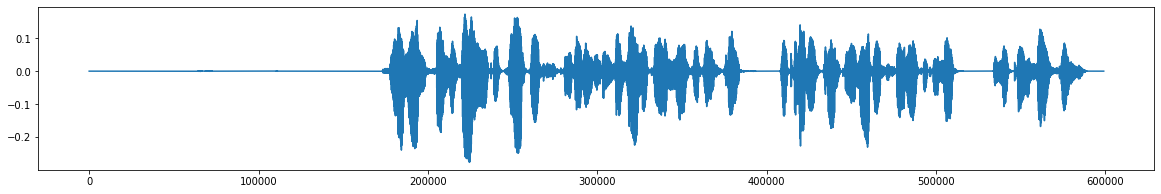

In [43]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(data)

In [44]:
# removing silence
clips = librosa.effects.split(data, top_db=10)
wav_data = []
for c in clips:
    audio_data = data[c[0]: c[1]]
    wav_data.extend(audio_data)

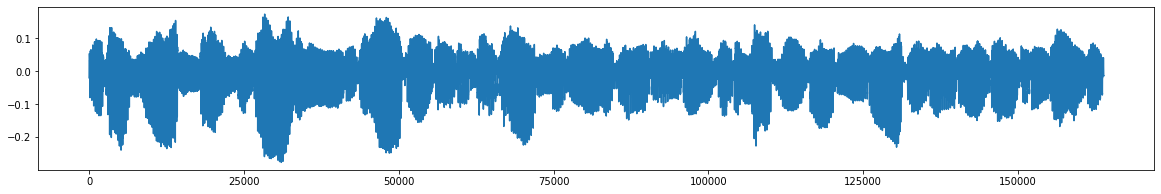

In [45]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(wav_data)

In [46]:
IPython.display.Audio(data=wav_data, rate=sample_rate)

In [48]:
from pyspark.sql.functions import isnan, when, count, col

In [49]:
df_spark.select([count(when(isnan(c), c)).alias(c) for c in df_spark.columns]).show()


+--------+--------+----+-----+-------+----+
|headline|category|date|views|article|link|
+--------+--------+----+-----+-------+----+
|       0|       0|   0|    0|      0|   0|
+--------+--------+----+-----+-------+----+



In [50]:
#checking for missing value
df_spark.select([count(when(col(c).isNull(), c)).alias(c) for c in df_spark.columns]).show()

+--------+--------+------+------+-------+------+
|headline|category|  date| views|article|  link|
+--------+--------+------+------+-------+------+
|      14|  108851|117446|117535| 117587|128302|
+--------+--------+------+------+-------+------+



In [52]:
df_spark.summary().show()

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|summary|            headline|            category|                date|               views|             article|                link|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  count|              169125|               60288|               51693|               51604|               51552|               40837|
|   mean|  495.77272727272725|               669.0|   767.2307692307693|   631.4789185326346|               179.5|   455.2857142857143|
| stddev|   850.1320307440308|   609.5773711585523|   757.8344315488877|  1650.3595756664436|  220.49263026232873|    412.466852925062|
|    min|\tfont-family:”Ca...|  (Ethiopia Nigd ...|       (Dashen Bira)|  (ArbaMinch Ketema)|                    |     (Kidus Giorgis)|
|    25%|                 1.0|               300

In [53]:
#filtering out null values 
df_spark_clean=df_spark.filter(df_spark.headline.isNotNull() & df_spark.category.isNotNull() & df_spark.article.isNotNull())

In [55]:
df_spark_clean.summary().show()

+-------+--------------------+--------------------+---------------+--------------------+--------------------+--------------------+
|summary|            headline|            category|           date|               views|             article|                link|
+-------+--------------------+--------------------+---------------+--------------------+--------------------+--------------------+
|  count|               51539|               51539|          51539|               51539|               51539|               40829|
|   mean|              1011.0|               392.0|           null|   631.8692491060787|               179.5|   455.2857142857143|
| stddev|  1425.5272708720797|  266.26002328550936|           null|   1650.882202651346|  220.49263026232873|    412.466852925062|
|    min|                   "|  (Ethiopia Nigd ...|  (Dashen Bira)|  (ArbaMinch Ketema)|                    |     (Kidus Giorgis)|
|    25%|                 3.0|               220.0|           null|                

In [57]:
# saving cleaned data into bucket
df_spark_clean.toPandas().to_csv('/mnt/10ac-batch-6/bucket/Data/clean.csv')

In [58]:
# Attempt to transform audio data
with open('records/reccc.wav', 'rb') as fd:
    contents = fd.read()

In [59]:
contents

b'RIFFFH\x12\x00WAVEfmt \x10\x00\x00\x00\x01\x00\x01\x00\x80\xbb\x00\x00\x00w\x01\x00\x02\x00\x10\x00LIST\x1a\x00\x00\x00INFOISFT\x0e\x00\x00\x00Lavf59.27.100\x00data\x00H\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

In [61]:
# binary_wave_rdd = spark_context.binaryFiles('records/reccc.wav')

In [62]:
sc = spark.sparkContext

In [63]:
sc.setLogLevel('WARN')

In [64]:
binary_wave_rdd = sc.binaryFiles('records/reccc.wav')

In [65]:
binary_wave_rdd = sc.binaryFiles('records/reccc.wav')
rdd = binary_wave_rdd.map(lambda x : (x[0], librosa.load(io.BytesIO(x[1]))))
coll = rdd.collect()

In [66]:
coll

[('file:/mnt/10ac-batch-6/notebooks/nahom_habtemichael/records/reccc.wav',
  (array([ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
           1.7884198e-05, -3.5712112e-06,  1.4689610e-06], dtype=float32),
   22050))]